The Needleman-Wunsch algorithm compares two arbitrary strings, and optimally under a given scoring scheme, returns the highest scoring alignment between the two.

Lets do a comparison of two gene orthologues for hemoglobin subunit beta, between the human and the mouse versions.

The indivudual mRNA sequences were obtained from NCBI, from

Human: http://www.ensembl.org/Homo_sapiens/Transcript/Summary?db=core;g=ENSG00000244734;r=11:5225464-5229395;t=ENST00000335295

Mouse: http://www.ensembl.org/Mus_musculus/Transcript/Summary?db=core;g=ENSMUSG00000073940;r=7:103812524-103813996;t=ENSMUST00000098192

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

human_HBB = "ATGGTGCATCTGACTCCTGAGGAGAAGTCTGCCGTTACTGCCCTGTGGGGCAAGGTGAACGTGGATGAAGTTGGTGGTGAGGCCCTGGGCAGGCTGCTGGTGGTCTACCCTTGGACCCAGAGGTTCTTTGAGTCCTTTGGGGATCTGTCCACTCCTGATGCTGTTATGGGCAACCCTAAGGTGAAGGCTCATGGCAAGAAAGTGCTCGGTGCCTTTAGTGATGGCCTGGCTCACCTGGACAACCTCAAGGGCACCTTTGCCACACTGAGTGAGCTGCACTGTGACAAGCTGCACGTGGATCCTGAGAACTTCAGGCTCCTGGGCAACGTGCTGGTCTGTGTGCTGGCCCATCACTTTGGCAAAGAATTCACCCCACCAGTGCAGGCTGCCTATCAGAAAGTGGTGGCTGGTGTGGCTAATGCCCTGGCCCACAAGTATCACTAA"
mouse_HBB = "ATGGTGCACCTGACTGATGCTGAGAAGGCTGCTGTCTCTGGCCTGTGGGGAAAGGTGAACGCCGATGAAGTTGGTGGTGAGGCCCTGGGCAGGCTGCTGGTTGTCTACCCTTGGACCCAGCGGTACTTTGATAGCTTTGGAGACCTATCCTCTGCCTCTGCTATCATGGGTAATGCCAAAGTGAAGGCCCATGGCAAGAAAGTGATAACTGCCTTTAACGATGGCCTGAATCACTTGGACAGCCTCAAGGGCACCTTTGCCAGCCTCAGTGAGCTCCACTGTGACAAGCTGCATGTGGATCCTGAGAACTTCAGGCTCCTGGGCAATATGATCGTGATTGTGCTGGGCCACCACCTGGGCAAGGATTTCACCCCCGCTGCACAGGCTGCCTTCCAGAAGGTGGTGGCTGGAGTGGCTGCTGCCCTGGCTCACAAGTACCACTAA"


In order to perform alignment, we need to define a scoring function for sequences. A good starting point is to use a score of 1 for a match, -1 for a mismatch and -1 for a gaps

In [9]:
def match_score(a,b):
  if a == b:
    return 1
  else:
    return -1

gap_score = -1

In [11]:

def NeedlemanWunsch(query, subject, scorefunc):
    t0 = time.perf_counter()
    nwmatrix = np.zeros((len(query) + 1, len(subject) + 1))

    # Initialize first row and column with gap penalties
    for i in range(len(query) + 1):
        nwmatrix[i][0] = i * gap_score
    for j in range(len(subject) + 1):
        nwmatrix[0][j] = j * gap_score

    # Fill in the matrix
    for q in range(1, len(query) + 1):
        for s in range(1, len(subject) + 1):
            nwmatrix[q, s] = max(
                nwmatrix[q - 1, s - 1] + scorefunc(query[q - 1], subject[s - 1]),  # Diagonal (match/mismatch)
                nwmatrix[q - 1, s] + gap_score,  # Up (gap in subject)
                nwmatrix[q, s - 1] + gap_score   # Left (gap in query)
            )

    # Traceback
    alignment_query, alignment_subject = "", ""
    q, s = len(query), len(subject)
    while q > 0 or s > 0:
        current_score = nwmatrix[q, s]
        if q > 0 and s > 0 and current_score == nwmatrix[q - 1, s - 1] + scorefunc(query[q - 1], subject[s - 1]):
            alignment_query = query[q - 1] + alignment_query
            alignment_subject = subject[s - 1] + alignment_subject
            q -= 1
            s -= 1
        elif q > 0 and current_score == nwmatrix[q - 1, s] + gap_score:
            alignment_query = query[q - 1] + alignment_query
            alignment_subject = "-" + alignment_subject
            q -= 1
        else:
            alignment_query = "-" + alignment_query
            alignment_subject = subject[s - 1] + alignment_subject
            s -= 1

    alignment_score = nwmatrix[len(query), len(subject)]
    print("Alignment performed in %.3f seconds" % (time.perf_counter() - t0))
    print("Query Alignment:", alignment_query)
    print("Subject Alignment:", alignment_subject)
    print("Alignment Score:", alignment_score)

    sns.heatmap(nwmatrix)
    plt.show()
    return alignment_score


The total alignment score is also present in the bottom right corner of the matrix.
If the traceback is not required, then often times just returning the score is sufficient

Alignment performed in 0.308 seconds
Query Alignment: ATGGTGCATCTGACTCCTGAGGAGAAGTCTGCCGT-TACTGCCCTGTGGGGCAAGGTGAACGTGGATGAAGTTGGTGGTGAGGCCCTGGGCAGGCTGCTGGTGGTCTACCCTTGGACCCAGAGGTTCTTTGAGT-CCTTTGGGGATCTGTCCACT-CCTGATGCTGTTATGGGCAA-CCCTAAGGTGAAGGCTCATGGCAAGAAAGTGCTCGGTGCCTTTAGTGATGGCCTGGCTCACCTGGACAACCTCAAGGGCACCTTTGCCA-CACTGAGTGAGCTGCACTGTGACAAGCTGCACGTGGATCCTGAGAACTTCAGGCTCCTGGGCAACGTGCTGGT-CTGTGTGCTGGCCCATCACTTTGGCAAAGAATTCACCCCAC-CAGTGCAGGCTGCCTAT-CAGAAAGTGGTGGCTGGTGTGGCTAATGCCCTGGCCCACAAGTATCACTAA
Subject Alignment: ATGGTGCACCTGACTGATGCTGAGAAGGCTGCTGTCT-CTGGCCTGTGGGGAAAGGTGAACGCCGATGAAGTTGGTGGTGAGGCCCTGGGCAGGCTGCTGGTTGTCTACCCTTGGACCCAGCGGTACTTTGA-TAGCTTTGGAGACCTATCCTCTGCCT-CTGCTATCATGGGTAATGCC-AAAGTGAAGGCCCATGGCAAGAAAGTGATAACTGCCTTTAACGATGGCCTGAATCACTTGGACAGCCTCAAGGGCACCTTTGCCAGC-CTCAGTGAGCTCCACTGTGACAAGCTGCATGTGGATCCTGAGAACTTCAGGCTCCTGGGCAATATGATCGTGAT-TGTGCTGGGCCACCACCTGGGCAAGGATTTCACCCC-CGCTGCACAGGCTGCCT-TCCAGAAGGTGGTGGCTGGAGTGGCTGCTGCCCTGGCTCACAAGTACCACTAA
Alignment Score: 302.

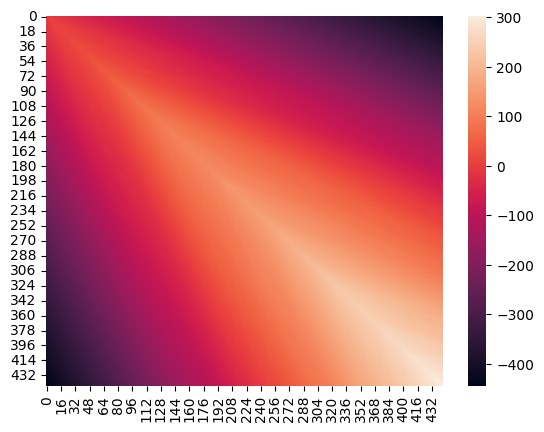

In [12]:

score = NeedlemanWunsch(human_HBB,mouse_HBB,match_score)



Note the time it takes to run your algorithm. I will give extra credit to the fastest implementations. Naturally, you dont have to include the drawing of the diagrams inside the calculation.


Next, try to implement the Smith Waterman Algorithm:

In [14]:

def SmithWaterman(query,subject,scorefunc):
    t0 = time.perf_counter()
    swmatrix = np.zeros((len(query) + 1, len(subject) + 1))

    max_score = 0
    max_pos = (0, 0)

    # Fill in the matrix
    for q in range(1, len(query) + 1):
        for s in range(1, len(subject) + 1):
            score = max(
                swmatrix[q - 1, s - 1] + scorefunc(query[q - 1], subject[s - 1]),  # Diagonal
                swmatrix[q - 1, s] + gap_score,  # Up
                swmatrix[q, s - 1] + gap_score,  # Left
                0  # Zero (no alignment)
            )
            swmatrix[q, s] = score
            if score > max_score:
                max_score = score
                max_pos = (q, s)

    # Traceback
    alignment_query, alignment_subject = "", ""
    q, s = max_pos
    while swmatrix[q, s] > 0:
        current_score = swmatrix[q, s]
        if q > 0 and s > 0 and current_score == swmatrix[q - 1, s - 1] + scorefunc(query[q - 1], subject[s - 1]):
            alignment_query = query[q - 1] + alignment_query
            alignment_subject = subject[s - 1] + alignment_subject
            q -= 1
            s -= 1
        elif q > 0 and current_score == swmatrix[q - 1, s] + gap_score:
            alignment_query = query[q - 1] + alignment_query
            alignment_subject = "-" + alignment_subject
            q -= 1
        elif s > 0 and current_score == swmatrix[q, s - 1] + gap_score:
            alignment_query = "-" + alignment_query
            alignment_subject = subject[s - 1] + alignment_subject
            s -= 1
        else:
            break

    print("Alignment performed in %.3f seconds" % (time.perf_counter() - t0))
    print("Query Alignment:", alignment_query)
    print("Subject Alignment:", alignment_subject)
    print("Alignment Score:", max_score)

    fig, ax = plt.subplots(figsize=(25, 10))
    sns.heatmap(swmatrix)
    plt.show()
    return max_score

And compare the coding region of human_HBB with the entire mRNA transcript of human_HBB_CDS!

Are there multiple candidate matches? Are there multiple regions of long matches?


Needleman-Wunsch Alignment:
Alignment performed in 0.000 seconds
Query Alignment: ACTGA-C
Subject Alignment: ACTGATC
Alignment Score: 5.0


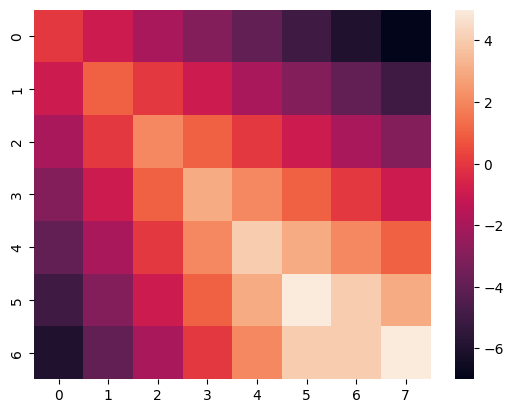

Smith-Waterman Alignment:
Alignment performed in 0.000 seconds
Query Alignment: ACTGA
Subject Alignment: ACTGA
Alignment Score: 5.0


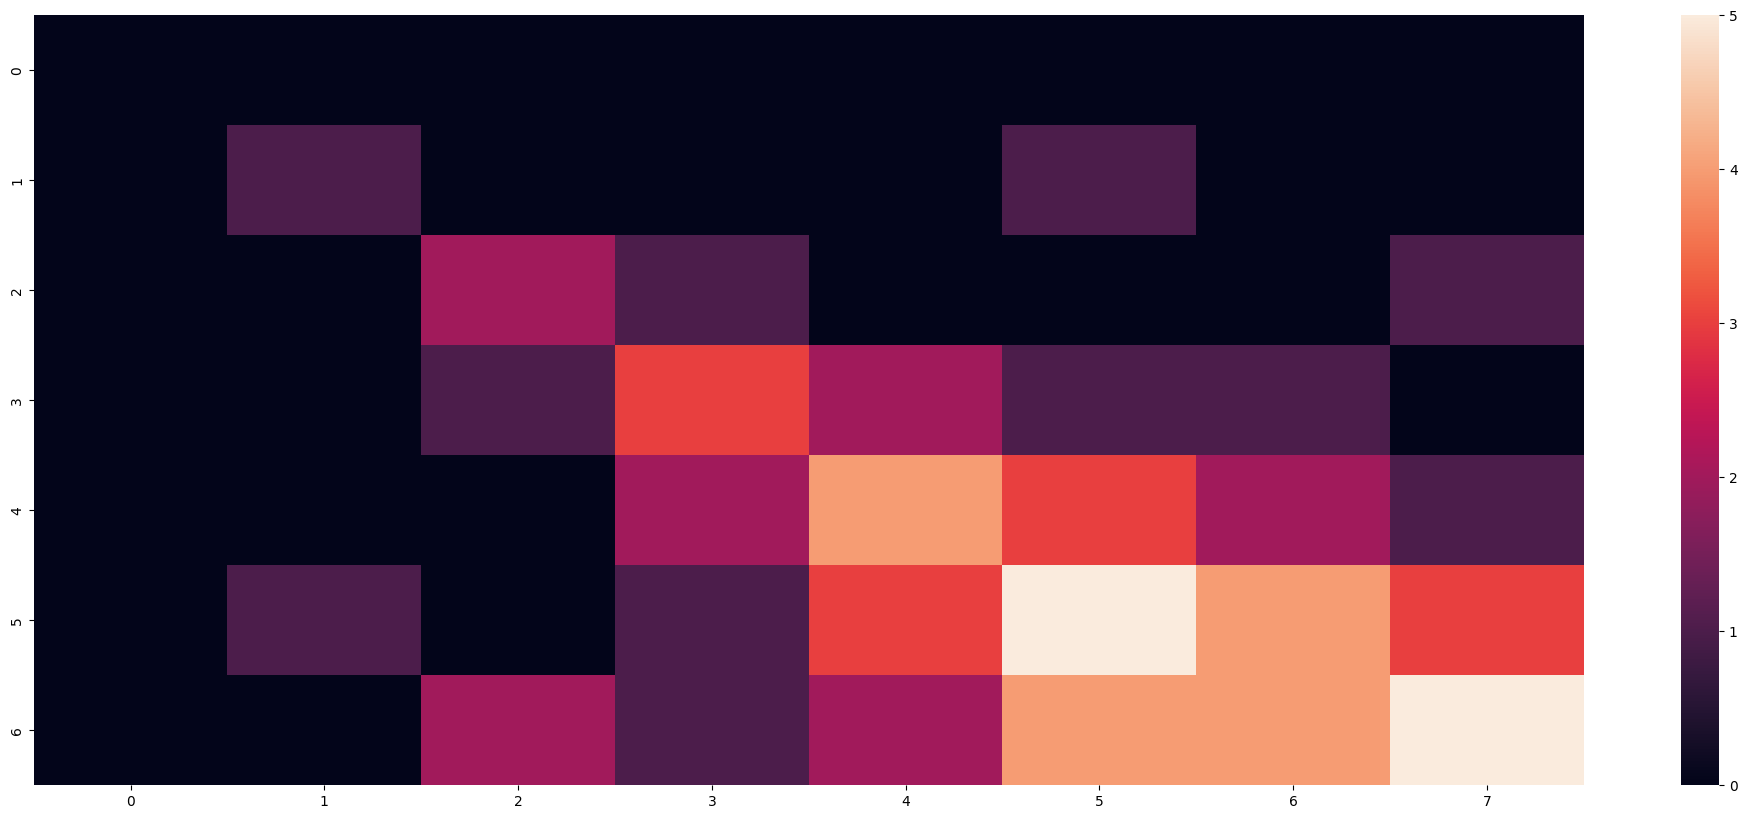

In [15]:
human_HBB = "ACTGAC"
human_HBB_CDS = "ACTGATC"

print("Needleman-Wunsch Alignment:")
score_nw = NeedlemanWunsch(human_HBB, human_HBB_CDS, match_score)

print("Smith-Waterman Alignment:")
score_sw = SmithWaterman(human_HBB, human_HBB_CDS, match_score)